Data Preprocessing
========================

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import argparse

In [2]:
df = pd.read_csv("EBITDA_preprocess.csv")
df.head()

,tic,datafqtr,cshoq,cshtrq,capxy,niq,xoprq,teqq,atq,epsfiq,...,MVA,CFROI,conm,EBITDA,SALE PRICE,Real GDP SA(billion),M2 SA(billion),M2-M1 SA(billion),M2V,Prime Rate(%)
0,NLP,2010Q1,10.666,263614.0,0.0,-2.568,11.450,63.433,309.571,-0.23,...,-245.5828,NaN,NTS REALTY HOLDINGS LP,-0.002,596771.895388,16582.710,8509.766667,6814.300000,1.735,3.25
1,NLP,2010Q2,10.666,235341.0,0.0,-2.608,12.143,59.999,304.493,-0.23,...,-257.3527,NaN,NTS REALTY HOLDINGS LP,-0.001,623600.673062,16743.162,8597.600000,6884.033333,1.742,3.25
2,NLP,2010Q3,10.666,159175.0,0.0,-3.197,11.950,55.925,299.536,-0.28,...,-254.1529,NaN,NTS REALTY HOLDINGS LP,-0.006,645188.876686,16872.266,8682.300000,6936.000000,1.744,3.25
3,NLP,2010Q4,10.666,163338.0,0.0,-3.023,11.716,52.167,328.566,-0.26,...,-228.8967,NaN,NTS REALTY HOLDINGS LP,-0.003,956586.999871,16960.864,8793.633333,6978.466667,1.741,3.25
4,NLP,2011Q1,10.666,177414.0,0.0,-3.392,12.967,48.098,325.605,-0.30,...,-281.8112,NaN,NTS REALTY HOLDINGS LP,-0.006,607552.961452,16920.632,8907.066667,7036.100000,1.724,3.25


# Rename columns for better readability

In [3]:
# Rename DataFrame columns to follow camelCase convention and match original definitions from the images

# Basic company identifiers
df = df.rename(columns={
    'tic': 'ticker',  # Stock ticker symbol
    'datafqtr': 'fiscalQuarter',  # Fiscal quarter date
    'conm': 'companyName'  # Company name
})

# Target variables (what we're trying to predict)
df = df.rename(columns={
    'EBITDA': 'EBITDA',  # Earnings Before Interest, Taxes, Depreciation and Amortization (target2)
    'SALE PRICE': 'salePrice'  # Mean sale price per quarter (from additional variables)
})

# Basic financial variables (raw data from financial statements)
df = df.rename(columns={
    'cshoq': 'commonSharesOutstanding_',  # Number of common shares outstanding
    'cshtrq': 'commonSharesTraded_',  # Common shares traded
    'capxy': 'capitalExpenditure_',  # Funds used to acquire/upgrade physical assets
    'niq': 'netIncome_',  # Net income (profit after all expenses)
    'xoprq': 'operatingIncome_',  # Operating income after depreciation
    'teqq': 'shareholdersEquity_',  # Total shareholders' equity
    'atq': 'totalAssets_',  # Total assets on balance sheet
    'epsfiq': 'EPS_'  # Earnings per share (profit per outstanding share)
})

# Engineered financial features (calculated metrics)
df = df.rename(columns={
    'Debt_to_TA': 'debtToTotalAssets',  # Total debt divided by total assets
    'NI_to_Asset': 'niToAsset',  # Net income divided by average assets
    'ROA': 'ROA',  # Return on assets (net income/total assets)
    'ROE': 'ROE',  # Return on equity (net income/shareholders' equity)
    'Revenue_growth': 'revenueGrowth',  # Quarter-over-quarter revenue growth
    'NI_growth': 'netIncomeGrowth',  # Quarter-over-quarter net income growth
    'Quick_ratio': 'quickRatio',  # (Current assets - inventories)/current liabilities
    'RSI': 'rsi',  # Relative Strength Index (momentum indicator)
    'MVA': 'mva',  # Market Value Added (not explicitly defined in images)
    'CFROI': 'cfroi'  # Cash flow return on investment (OCF/Capital Employed)
})

# Macroeconomic variables (external factors)
df = df.rename(columns={
    'Real GDP SA(billion)': 'realGDPSA',  # Seasonally adjusted real GDP
    'M2 SA(billion)': 'm2SA',  # Seasonally adjusted M2 money supply
    'M2-M1 SA(billion)': 'm2MinusM1SA',  # Difference between M2 and M1 money supply
    'M2V': 'm2Velocity',  # Velocity of M2 money supply
    'Prime Rate(%)': 'primeRate'  # Benchmark interest rate
})

# Note: Some variables from the images weren't found in the original column list:
# - Revenue (revtq) - appears to be missing from original columns
# - Rooms Expenses (gmrmexpoq)
# - Room Revenue (gmrnewq)
# - Various homebuilding inventory metrics
# These would need to be added if present in the dataset


In [4]:
print(df.columns.tolist())

['ticker', 'fiscalQuarter', 'commonSharesOutstanding_', 'commonSharesTraded_', 'capitalExpenditure_', 'netIncome_', 'operatingIncome_', 'shareholdersEquity_', 'totalAssets_', 'EPS_', 'debtToTotalAssets', 'niToAsset', 'ROA', 'ROE', 'revenueGrowth', 'netIncomeGrowth', 'quickRatio', 'rsi', 'mva', 'cfroi', 'companyName', 'EBITDA', 'salePrice', 'realGDPSA', 'm2SA', 'm2MinusM1SA', 'm2Velocity', 'primeRate']


# Company selection

In [5]:
unique_tic_names = df['ticker'].unique()
print(unique_tic_names)
print(len(unique_tic_names))

['NLP' 'NMRK' 'ASPS' 'ATMFF.1' 'ALBT' 'AOXY' 'MAMP' 'MAYS' 'ARL' 'MMI'
 'MNGGF' 'MODVF' 'MRCBF' 'TH' 'TNL' 'PGCG' 'PKTEF' 'BCKMF' 'BEEP' 'BEKE'
 'MYHI.1' 'NEN' 'XIN' 'YYLRA' 'ZIPR' 'VTMX' 'VWTR' 'BSIRY' 'BSKS' 'CBRE'
 'GZTGF' 'NNP.' 'NTPIF' 'PRLEQ' 'PRRE' 'PUB.Z' 'TPHS' 'TPRP' 'UK' 'GV'
 'GYRO' 'CHIT' 'RMAX' 'ROII.1' 'SGD' 'RDFN' 'GEBRF' 'GGEI' 'CIGI' 'HOFD'
 'HOUS' 'CKX' 'TCN' 'CTCLY' 'CTYV' 'CWK' 'WAYS' 'WEWKQ' 'WFICF' 'STRS'
 'SVAUF' 'OMH' 'OPAD' 'OPEN' 'UOKA' 'VAMA.1' 'VLTC' 'HMT.' 'EJ' 'EUDA'
 'EXPI' 'SYSW' 'SYT' 'TCI' 'FCXXF' 'FHRT' 'DGTC' 'DHOXY' 'DNK' 'DOUG'
 'NWBA' 'NXLCF' 'VSE' 'MDPCF' 'MHIVF' '3CPTA' '5305B' '7634B' 'ACAN'
 'MYCB' 'GNLAF' 'LCANF' 'LEJUY' 'WLSE' 'WSC' 'LRHC' 'LTFD' 'LUXH' 'IRS'
 'JKA' 'JLL' 'OMAGQ' 'SIRC' 'SRG' 'SRRE' 'STHO' 'STON' 'GBR' 'BPY' 'BREUF'
 'FTHM' 'FRPH' 'FRWL' 'FSV' 'GADS' 'RLLMF' 'MLLS' 'MLP' 'WZI.H' 'IRCP']
120


In [6]:
nyc_real_estate_tickers = [
    'NMRK',  # Newmark Group, Inc.
    'CBRE',  # CBRE Group, Inc.
    'CWK',   # Cushman & Wakefield plc
    'DOUG',  # Douglas Elliman Inc.
    'JLL',   # Jones Lang LaSalle Inc.
    'HOUS',  # Anywhere Real Estate Inc.
    'RMAX',  # RE/MAX Holdings, Inc.
    'EXPI',  # eXp World Holdings, Inc.
    'OPEN',  # Opendoor Technologies Inc.
    'OPAD',  # Offerpad Solutions Inc.
    'BEKE',  # KE Holdings Inc. (Limited NYC presence)
    'RDFN',  # Redfin Corporation
    'CIGI',  # Colliers International Group Inc.
    'FSV',   # FirstService Corporation
    'TCN',   # Tricon Residential Inc.

    # The following are private companies without tickers
    # 'Silverstein Properties',
    # 'Thor Equities',
    # 'JDS Development Group',
    # 'Charney Companies'
]
# Check if these tickers are in the DataFrame, which are not in the original list
for ticker in nyc_real_estate_tickers:
    if ticker not in df['ticker'].values:
        print(f"{ticker} is not in the DataFrame")
    else:
        print(f"{ticker} is in the DataFrame")

NMRK is in the DataFrame
CBRE is in the DataFrame
CWK is in the DataFrame
DOUG is in the DataFrame
JLL is in the DataFrame
HOUS is in the DataFrame
RMAX is in the DataFrame
EXPI is in the DataFrame
OPEN is in the DataFrame
OPAD is in the DataFrame
BEKE is in the DataFrame
RDFN is in the DataFrame
CIGI is in the DataFrame
FSV is in the DataFrame
TCN is in the DataFrame


In [7]:
EBITDA_df = df[df['ticker'].isin(nyc_real_estate_tickers)]
EBITDA_df.head()

,ticker,fiscalQuarter,commonSharesOutstanding_,commonSharesTraded_,capitalExpenditure_,netIncome_,operatingIncome_,shareholdersEquity_,totalAssets_,EPS_,...,mva,cfroi,companyName,EBITDA,salePrice,realGDPSA,m2SA,m2MinusM1SA,m2Velocity,primeRate
16,NMRK,2015Q4,NaN,NaN,12.133,-2.803,1142.439,804.034,1657.930,-0.02,...,NaN,0.415438,NEWMARK GROUP INC,-0.584,1.281597e+06,18892.206,12290.766667,9224.500000,1.500,3.290323
17,NMRK,2016Q1,NaN,NaN,12.133,-2.803,1142.439,804.034,1657.930,-0.02,...,NaN,0.415438,NEWMARK GROUP INC,-0.475,1.177307e+06,19001.690,12571.066667,9435.233333,1.474,3.500000
18,NMRK,2016Q2,NaN,NaN,12.133,-2.803,1142.439,804.034,1657.930,-0.02,...,NaN,0.415438,NEWMARK GROUP INC,-0.431,1.336356e+06,19062.709,12772.800000,9546.333333,1.465,3.500000
19,NMRK,2016Q3,NaN,NaN,12.133,-2.803,1142.439,804.034,1657.930,-0.02,...,NaN,0.415438,NEWMARK GROUP INC,-0.526,9.994895e+05,19197.938,12965.933333,9675.100000,1.457,3.500000
20,NMRK,2016Q4,NaN,NaN,27.260,168.401,1123.520,983.783,2534.688,1.07,...,NaN,-0.574873,NEWMARK GROUP INC,-0.359,1.111994e+06,19304.352,13171.533333,9830.033333,1.449,3.545082


In [8]:
EBITDA_df.shape[0]
# Check for missing values in the DataFrame

266

# Preprocessing Steps

## Numerical features

### Process Null values
<!-- 
EPS_                         9
commonSharesOutstanding_    24
commonSharesTraded_         54
quickRatio                  10
rsi                         64
mva                         70
cfroi                       10 -->

In [9]:
# Check for missing values in the DataFrame
missing_values = EBITDA_df.isnull().sum()
print(missing_values)

# Drop columns with missing values
EBITDA_df = EBITDA_df.drop(columns=missing_values[missing_values > 0].index.tolist())
print("Columns with missing values have been dropped.")

ticker                       0
fiscalQuarter                0
commonSharesOutstanding_    24
commonSharesTraded_         54
capitalExpenditure_          0
netIncome_                   0
operatingIncome_             0
shareholdersEquity_          0
totalAssets_                 0
EPS_                         9
debtToTotalAssets            0
niToAsset                    0
ROA                          0
ROE                          0
revenueGrowth                0
netIncomeGrowth              0
quickRatio                  10
rsi                         64
mva                         70
cfroi                       10
companyName                  0
EBITDA                       0
salePrice                    0
realGDPSA                    0
m2SA                         0
m2MinusM1SA                  0
m2Velocity                   0
primeRate                    0
dtype: int64
Columns with missing values have been dropped.


In [10]:
num_features = ['commonSharesOutstanding', 'commonSharesTraded', 'capitalExpenditure',
                'netIncome', 'operatingIncome', 'shareholdersEquity', 'totalAssets',
                'eps', 'salePrice', 'realGdpSA', 'm2SA', 'm2MinusM1SA', 'm2Velocity',
                'primeRate']

In [11]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='median')  # Median is robust to outliers
# X_num_imputed = imputer.fit_transform(X[num_features])

In [12]:
print(f"The DataFrame has {EBITDA_df.shape[1]} columns.")

The DataFrame has 21 columns.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

def handle_outliers(df, columns):
    for col in columns:
        # 使用IQR法
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 截断处理
        # 也可以用winsorization方法
        df[col] = df[col].clip(lower_bound, upper_bound)
    return df

def preprocess_numeric_data(df):
    # 1. 缺失值处理
    missing_ratio = df.isnull().sum() / len(df)
    df = df.drop(columns=missing_ratio[missing_ratio > 0.3].index)
    for col in df.select_dtypes(include=['float64', 'int64']):
        df[col].fillna(df[col].median(), inplace=True)
    
    # 2. 异常值处理（IQR法）
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    ratio_cols = ['debtToTotalAssets', 'ROA', 'quickRatio']  # 排除比率列
    cols_to_process = list(set(numeric_cols) - set(ratio_cols))
    df = handle_outliers(df, cols_to_process)
    
    # 3. 特征工程
    # df['asset_turnover'] = df['revenue'] / df['totalAssets_']
    # df['operating_margin'] = df['operatingIncome_'] / df['revenue']
    
    # 4. 时间序列特征（若为面板数据）
    df = df.sort_values(['ticker', 'fiscalQuarter'])
    df['EBITDA_lag1'] = df.groupby('ticker')['EBITDA'].shift(1)
    
    # 5. 多重共线性处理
    df = df.drop(columns=['ROE'])  # 假设与ROA高度相关
    
    scale_columns = [
        'capitalExpenditure_',
        'netIncome_', 'operatingIncome_', 'shareholdersEquity_', 'totalAssets_',
        'salePrice', 'realGDPSA', 'm2SA', 'm2MinusM1SA', 'm2Velocity'
    ]
    
    # 2. 时间特征处理（从fiscalQuarter提取年份和季度）
    df['year'] = df['fiscalQuarter'].str[:4].astype(int)
    df['quarter'] = df['fiscalQuarter'].str[-1].astype(int)
    
    # 3. 删除冗余列（可选）
    # df = df.drop(columns=['companyName'])  # 与ticker重复
    
    # 4. 特征缩放
    scaler = StandardScaler()
    df[scale_columns] = scaler.fit_transform(df[scale_columns])
    return df

# 执行预处理
processed_df = preprocess_numeric_data(EBITDA_df.copy())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py

In [17]:
processed_df.head()

,ticker,fiscalQuarter,capitalExpenditure_,netIncome_,operatingIncome_,shareholdersEquity_,totalAssets_,debtToTotalAssets,niToAsset,ROA,...,EBITDA,salePrice,realGDPSA,m2SA,m2MinusM1SA,m2Velocity,primeRate,EBITDA_lag1,year,quarter
533,BEKE,2018Q4,2.110696,-1.671030,2.138782,1.066984,0.562328,-0.382122,-0.012037,-0.012037,...,1.033,0.307338,0.099404,-0.313560,1.027312,0.370390,5.278226,NaN,2018,4
534,BEKE,2019Q1,2.110696,-1.671030,2.138782,1.066984,0.562328,-0.382122,-0.012037,-0.012037,...,0.774,-0.095360,0.171741,-0.268176,1.069768,0.340064,5.500000,1.033,2019,1
535,BEKE,2019Q2,2.110696,1.742166,2.126464,1.066984,0.562328,-0.382122,-0.012037,-0.012037,...,0.813,1.156217,0.269111,-0.226295,1.101358,0.352194,5.500000,0.774,2019,2
536,BEKE,2019Q3,2.110696,1.742166,2.126464,1.066984,0.562328,-0.382122,-0.012037,-0.012037,...,0.781,0.936142,0.406660,-0.159157,1.157002,0.315803,5.307692,0.813,2019,3
537,BEKE,2019Q4,2.110696,-1.671030,2.138782,2.237921,1.565130,-0.468720,-0.040849,-0.040849,...,0.782,0.837412,0.487761,-0.081541,1.217345,0.212694,4.834677,0.781,2019,4


# Preprocessing Performance Comparison

## Verify outliers detection

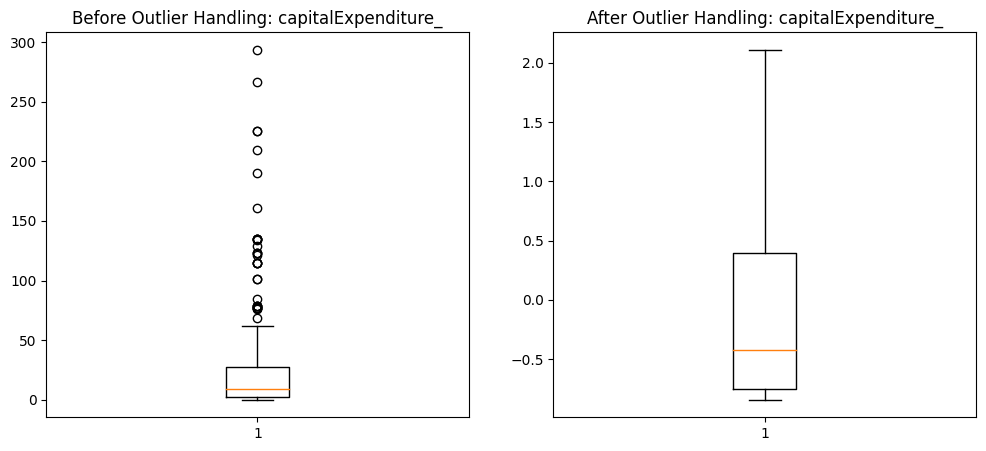

In [ ]:
import matplotlib.pyplot as plt

def compare_outliers(df_before, df_after, column):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.boxplot(df_before[column].dropna())
    plt.title(f"Before Outlier Handling: {column}")
    
    plt.subplot(1, 2, 2)
    plt.boxplot(df_after[column].dropna())
    plt.title(f"After Outlier Handling: {column}")
    
    plt.show()

# 示例：检查处理前后的capitalExpenditure_
compare_outliers(EBITDA_df, processed_df, 'capitalExpenditure_')


## Verify scaling performance

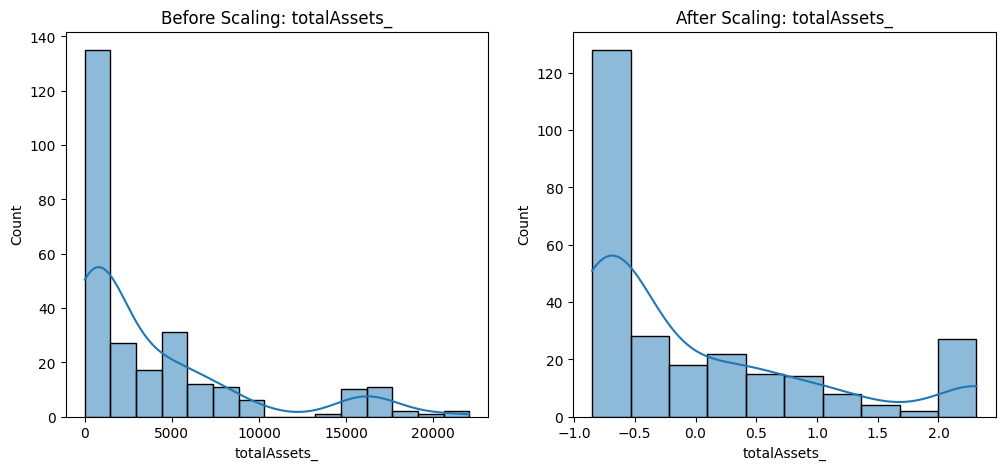

In [20]:
import seaborn as sns
def check_scaling(df_before, df_after, column):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df_before[column], kde=True)
    plt.title(f"Before Scaling: {column}")
    
    plt.subplot(1, 2, 2)
    sns.histplot(df_after[column], kde=True)
    plt.title(f"After Scaling: {column}")
    
    plt.show()

# 示例：检查totalAssets_的缩放效果
check_scaling(EBITDA_df, processed_df, 'totalAssets_')

## Check numerical features distribution after preprocessing

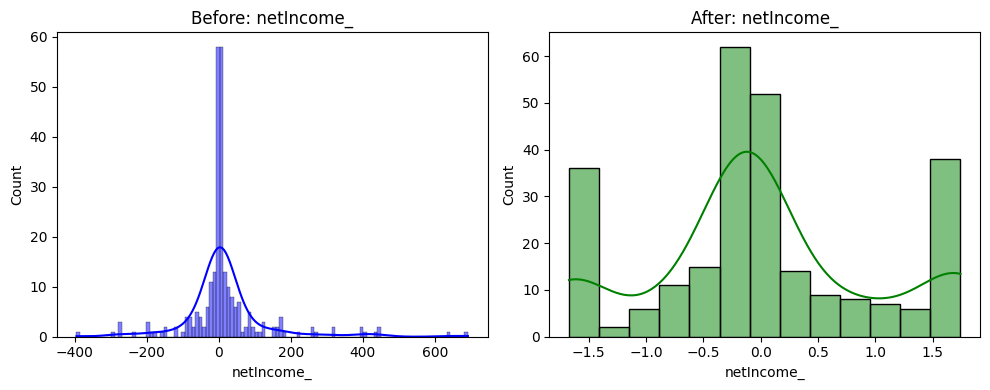

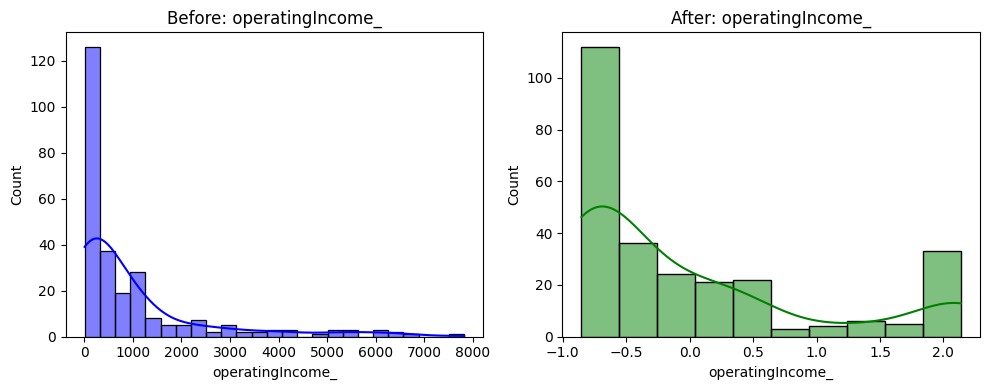

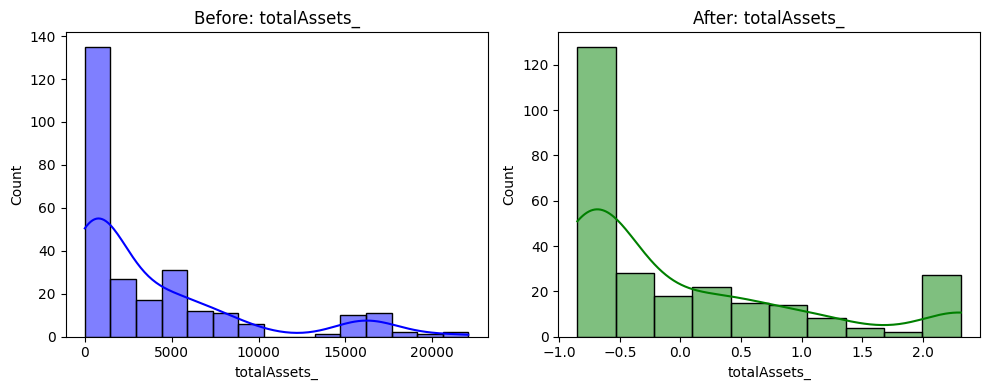

In [21]:
def plot_distribution_comparison(df_before, df_after, columns, log_scale=False):
    for col in columns:
        plt.figure(figsize=(10, 4))
        
        # 处理前分布
        plt.subplot(1, 2, 1)
        sns.histplot(df_before[col], kde=True, color='blue')
        if log_scale:
            plt.yscale('log')
        plt.title(f"Before: {col}")
        
        # 处理后分布
        plt.subplot(1, 2, 2)
        sns.histplot(df_after[col], kde=True, color='green')
        if log_scale:
            plt.yscale('log')
        plt.title(f"After: {col}")
        
        plt.tight_layout()
        plt.show()

# 示例：检查关键数值列
numeric_cols = ['netIncome_', 'operatingIncome_', 'totalAssets_']
plot_distribution_comparison(EBITDA_df, processed_df, numeric_cols)

## Check correlation matrix

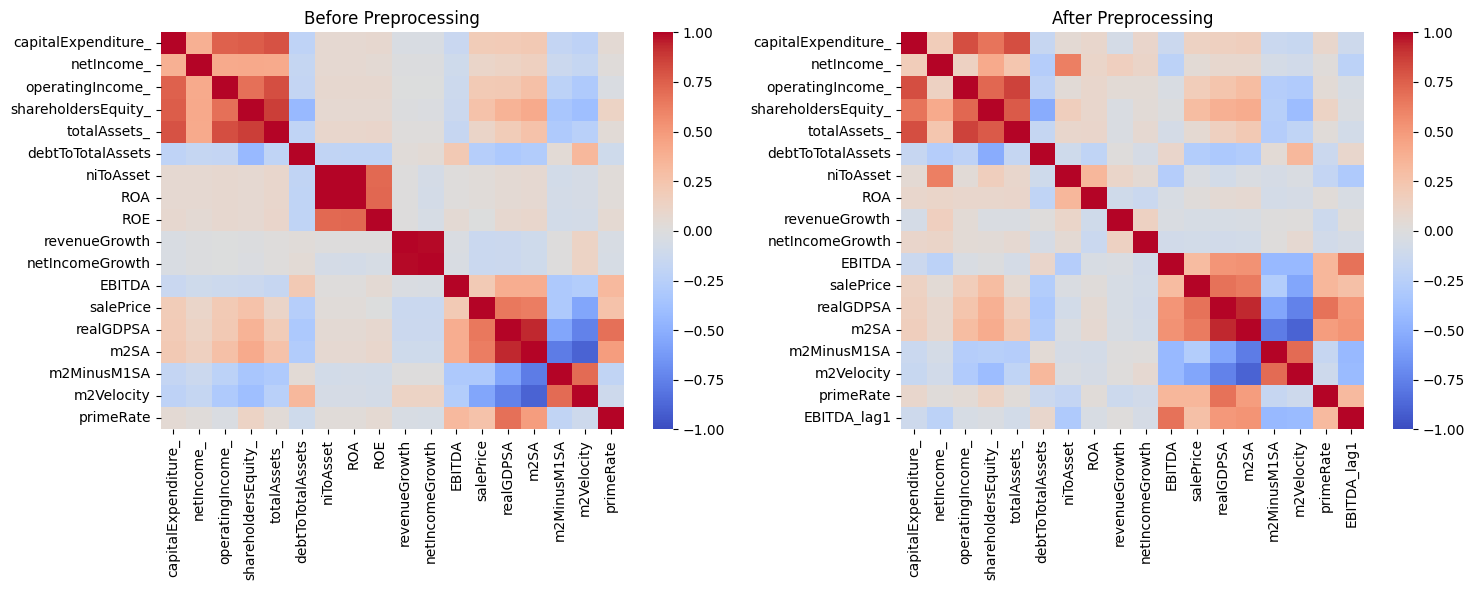

In [22]:
def compare_correlation(df_before, df_after):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(df_before.select_dtypes(include=['float64']).corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Before Preprocessing")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(df_after.select_dtypes(include=['float64']).corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("After Preprocessing")
    
    plt.tight_layout()
    plt.show()

compare_correlation(EBITDA_df, processed_df)

## Save files

In [ ]:
processed_df.to_csv("EBITDA_new.csv", index=False)
print("New CSV file created: EBITDA_new.csv")

New CSV file created: EBITDA_new.csv
